# Gaussian process system model for towing Kite

In this Jupyter Notebook we train the GP system model for the towing kite.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../do-mpc/')
import do_mpc
import pandas as pd
import scipy.io as sio
import pathlib

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as RBF_sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from skopt import BayesSearchCV, gp_minimize
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

from gp_tools import GPPredictModel
import gp_tools

from casadi import *

In [2]:
%matplotlib notebook

## Load prepared training / test and validation data

See Jupyter Notebook ``train_test_val_data_prep.ipynb`` for details.

In [3]:
load_name = 'S01_Prep_01'
load_path = './data_prep/'

data = do_mpc.tools.load_pickle(load_path + load_name + '.pkl')

nn_in_train_scaled = data['in_train_scaled']
nn_in_test_scaled = data['in_test_scaled']
nn_out_train_scaled = data['out_train_scaled']
nn_out_test_scaled = data['out_test_scaled']

# preprocessing.StandardScaler() objects:
in_scaler = data['in_scaler']
out_scaler = data['out_scaler']

# Test sequences:
test_res = data['test_res']

# GP with SKLearn

We use SKlearn to train the Gaussian process. As discussed in our paper, it is not feasible to consider all $m=3223$ training samples. Instead we select a subset (100 or 200), which is randomly drawn from the full training set.

In [4]:
%%capture

np.random.seed(99)
n_samples_gpr = 200
sample_ind = np.random.choice(np.arange(nn_in_train_scaled.shape[0]),n_samples_gpr)

X_grp = nn_in_train_scaled[sample_ind,:]
Y_grp = nn_out_train_scaled[sample_ind,:]

X_test = nn_in_test_scaled
Y_test = nn_out_test_scaled

alpha = 1e-10
gpr = GaussianProcessRegressor(kernel=RBF_sklearn(length_scale=0.1), alpha = alpha, random_state=0).fit(X_grp, Y_grp)

print(f'R2 score: {gpr.score(X_test, Y_test)}')

# We obtain the lenght scale from the optimized GP for our own reimplementation with CasADi.
l = gpr.kernel_.length_scale

## Open-loop predictions

Compute an open-loop prediction for one of the test cases. Choose the case with ``case = ...``.
The open-loop predictions are computed through the class ``GPPredictModel``.

In [5]:
case = 0

x0 = (test_res[case]['states'][0]).reshape(-1,1)

pm = GPPredictModel(gpr, in_scaler, out_scaler, x0)

for k in range(test_res[case]['states'].shape[0]):
    u0 = test_res[case]['input'][k]
    p = test_res[case]['wind'][k]
    pm.make_step(u0,p)

<IPython.core.display.Javascript object>


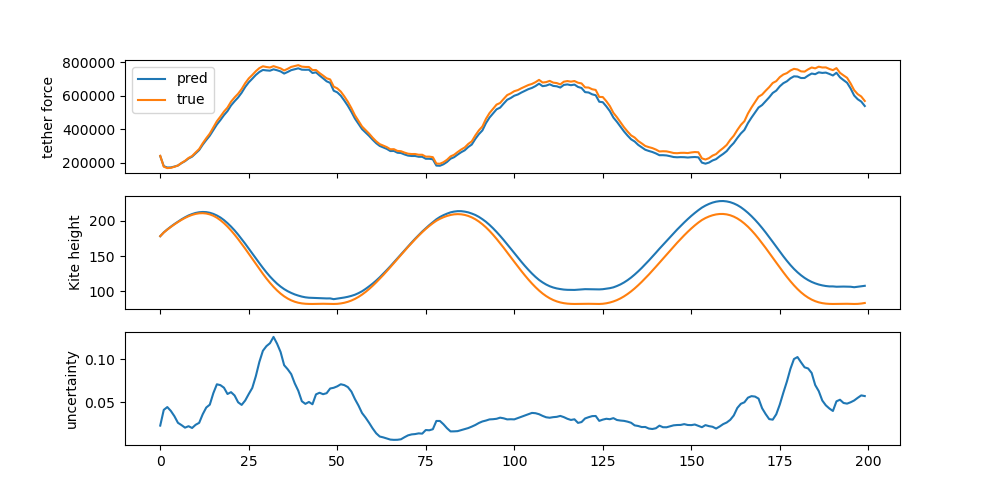

Text(0, 0.5, 'uncertainty')

In [6]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,5))

ax[0].plot(pm.aux[:,0],label='pred')
ax[0].plot(test_res[case]['T_F'], label='true')
ax[0].set_ylabel('tether force')
ax[0].legend()

ax[1].plot(pm.aux[:,1])
ax[1].plot(test_res[case]['height'])
ax[1].set_ylabel('Kite height')

ax[2].plot(pm.v)
ax[2].set_ylabel('uncertainty')

Compute open-loop predictions for all test cases:

In [7]:
gp_traj = []
gp_trust = []
n_eval = min(20,len(test_res))

for i, res_i in enumerate(test_res[:n_eval]):
    x0 = (res_i['states'][0]).reshape(-1,1)
    pm = GPPredictModel(gpr, in_scaler, out_scaler, x0)

    for k in range(res_i['states'].shape[0]):
        u0 = res_i['input'][k]
        p = res_i['wind'][k]
        pm.make_step(u0,p)
    
    gp_traj.append(pm.x)
    gp_trust.append(pm.v)

Plot all test cases ($\phi$, $\theta$ diagram) and flag points with trust violations.

<IPython.core.display.Javascript object>


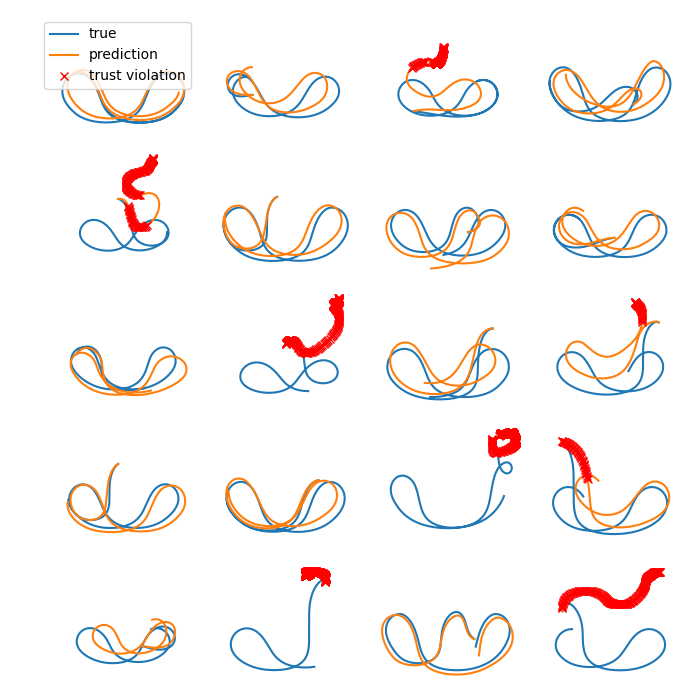

In [8]:
n_row = int(np.ceil(np.sqrt(n_eval)))
n_col = int(np.ceil(n_eval/n_row))

trust_threshold = 0.3


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(7,7))
for i, res_i in enumerate(test_res[:n_eval]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0], label='true')
    ax[i//n_col, np.mod(i,n_col)].plot(gp_traj[i][:,1], gp_traj[i][:,0], label='prediction')
    
    viol_ind = (gp_trust[i]>= trust_threshold).flatten()
    ax[i//n_col, np.mod(i,n_col)].plot(gp_traj[i][1:,:][viol_ind,1], gp_traj[i][1:,:][viol_ind,0],
                                      'x', color='red', label='trust violation')
    
    
for i in range(ax.size):
    ax[i//n_col, np.mod(i,n_col)].axis('off')

ax[0,0].legend()

fig.tight_layout()

## Export model

In [9]:
export_bool = False

if export_bool:
    export_name = 'S01_GP_M01_200'
    export_path = './gp_models/{}/'
    pathlib.Path(export_path.format(export_name)).mkdir(parents=True, exist_ok=True)

    export_dict = {'X_train': X_grp, 'Y_train': Y_grp, 'l': l, 'alpha': alpha,
                   'in_scaler': in_scaler, 'out_scaler': out_scaler}
    do_mpc.tools.save_pickle(export_path.format(export_name) + export_name + '_gp.pkl', export_dict)